# Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

c:\programdata\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Define parameters for image loading here:

In [8]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 4

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"H2ax":3,"Pol2Se":4}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
h2ax_key="H2ax"
pol2_key = 'Pol2Se'



# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"
data_save_folder = r"D:\Analyzed_CellBio\Stam\cov2_Mdc1-488 H2AX-568 PolS5-647\*"

data_files = [file for file in glob.glob(data_save_folder) if 'nd2' in file]
data_files

['D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_001.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_002.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_003.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_004.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_005.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_006.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_007.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov2_Mdc1-488 H2AX-568 PolS5-647\\cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_008.n

In [9]:
# bool setting for adjusting code indendation
_analyze_all_nd = True


# print progress
_verbose = True


# bad fovs to exclude
#fov_to_exclude = [7-1, 19-1]

fov_to_exclude_dict = {1:[4,5],5:[2,3]}

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion
#small_53BP_size = 300
# other parameteres for image analysis


small_53BP_size = 0

h2ax_border_size_filter = 1

#nuclei_filter = 5000 # for 1004

nuclei_filter = 600

iqr_ratio = 2

std_ratio = 3

#coord_dist = 75
#cell_size =400

po2_neg_percentile = 10


search_xylim = [300,1700]  # Note that DNA channel is not evenly illuminated

In [59]:
images = ND2Reader(data_files[2])

'v' in images.sizes.keys()

False

# Analyze each fovs and cells

In [224]:
measurement_for_all_fov_df = pd.DataFrame()

for data_ind, data in enumerate(data_files[:]):
    
    #measurement_for_all_fov = []
    
    data_name = data.split('\\')[-1]
    
    # load data of interest from preprocessed cell_info_dict
    #if data_name in cell_info_dict.keys():
    if _analyze_all_nd:
        if _verbose:
            print(f"-- Start analyzing the dataset of {data_name}")
        
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"]
        
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"]
        # single fov image
        else:
            num_of_fov = 1
        
        # exclude the focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
        
    #####################################################################################
        # going through all fov of interest
        for _fov_id in fov_of_interest: 
        
            # Find the best focal plane using the mdc1 (the factor key) channel   
            image_fl = []
            image_std = []
            for i in range(num_of_planes):
                # going through all focal planes [ch index starts from 0]
                image_array = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=i))
                _fl=image_array.flatten()
                image_fl.append(_fl)
                image_std.append(np.std(_fl))
            best_plane_index = np.argmax(np.array(image_std))
            if _verbose:
                print(f"-- Analyzing the plane {best_plane_index+1} for the image {_fov_id+1} in this dataset")
                
            # load the best focal plane
            img_1_bf=np.array(images.get_frame_2D (v=_fov_id, c= 0, z=best_plane_index))
            img_2_bf=np.array(images.get_frame_2D (v=_fov_id, c= 1, z=best_plane_index))
            img_3_bf=np.array(images.get_frame_2D (v=_fov_id, c= 2, z=best_plane_index))
            img_4_bf=np.array(images.get_frame_2D (v=_fov_id, c= 3, z=best_plane_index))
            
            if _analyze_all_nd:
                # Update/Generate the img_dict
                #ch_img_dict={'1':crop_img_1,'2':crop_img_2,'3':crop_img_3,'4':crop_img_4}
                ch_img_dict={'1':img_1_bf,'2':img_2_bf,'3':img_3_bf,'4':img_4_bf}
                

                # Use Li_global_th and binary operations on the dna (POL2) channel to generate nuclei masks
                li_value =  threshold_otsu (ch_img_dict[str(ch_dict[pol2_key])])
                nuclei_mask = ch_img_dict[str(ch_dict[pol2_key])]>li_value
                
                erosion_factor_dna = 3
                eroded_nuclei_mask = dilation(nuclei_mask, disk(erosion_factor_dna))
                eroded_nuclei_mask = erosion(eroded_nuclei_mask, disk(erosion_factor_dna))
                
                eroded_nuclei_mask = ndi.binary_fill_holes(eroded_nuclei_mask)
                eroded_nuclei_mask = remove_small_objects(eroded_nuclei_mask, nuclei_filter,connectivity=1)
                smoothed_nuclei_mask = skimage.filters.median (eroded_nuclei_mask, disk(10))
                
                
                # Generate mask for the non-cell/non-nuclei background
                noncell_background = erosion(smoothed_nuclei_mask==0,disk(10))
                    
                # Nuclei segmentation to get all valid nuclei of interest
                labeled_nuclei, num_of_nuclei = ndi.label(smoothed_nuclei_mask)
                
                # Prepare to analyze cell
                kept_nuclei_info = []
                for i in range(num_of_nuclei):
                    cand_nucleus = labeled_nuclei == i+1
                    cand_nucleus[cand_nucleus>0]=1
                    cand_nucleus = np.array(cand_nucleus)
                    
                    # find the labeled nuclei close enough to the given coord (with 50 pixel)
                    region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                    if region.centroid[0] > search_xylim[0] and region.centroid[0] < search_xylim[1]:
                        if region.centroid[1] > search_xylim[0] and region.centroid[1] < search_xylim[1]:
                            cell_xy = np.array([region.centroid[0],region.centroid[1]])
                            kept_nuclei_info.append([cand_nucleus,cell_xy])
                
                
                # Analyze each valid nuclei   
                for _cell_id, kept_nucleus_info in enumerate(kept_nuclei_info):
                        
                        
                    measurement_list = []    
                        
                    nuclei_to_measure = erosion(kept_nucleus_info[0], disk(3))
                    sel_nuclei_xy = kept_nucleus_info[1]
         
                    # Get cellular mdc mask 
                    mdc_intensity = (ch_img_dict[str(ch_dict[mdc1_key])])*nuclei_to_measure
                    mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                    mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*std_ratio
                    mdc_mask = np.logical_and(ch_img_dict[str(ch_dict[mdc1_key])]>mdc_positive_th, nuclei_to_measure)
                    if small_53BP_size == 0:
                        small_53BP_size = 30
                    mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                    
                    # Proceed if has MDC-positive foci
                    if np.sum(mdc_chr_mask)>=small_53BP_size:
                        
                        if _verbose:
                            print(f'-- Measuring cell {_cell_id+1} in fov {_fov_id+1}.')

                        # Generate masks for H2AX bright foci similarly but within the mdc-chr mask
                        h2ax_intensity = ch_img_dict[str(ch_dict[h2ax_key])]*nuclei_to_measure
                        h2ax_intensity_filtered = h2ax_intensity[h2ax_intensity!=0]
                        h2ax_positive_th = np.mean(h2ax_intensity_filtered) + 3* np.std(h2ax_intensity_filtered)
                        h2ax_foci_mask = np.logical_and((ch_img_dict[str(ch_dict[h2ax_key])] > h2ax_positive_th),mdc_chr_mask)
            
                        # mask for h2ax negative area within the incorporated chr; 
                        # note that border will counted for both so the add-up is bit larger than the incorporated chr mask
                        h2ax_negative_inc_chr_mask_rough = np.logical_xor(mdc_chr_mask,h2ax_foci_mask)
                        
                        # use both intensity and minus background to define the negative area 
                        h2ax_negative_th = np.mean(h2ax_intensity_filtered) + 2* np.std(h2ax_intensity_filtered)
                        h2ax_negative_inc_chr_mask = np.logical_and((ch_img_dict[str(ch_dict[h2ax_key])] < h2ax_negative_th)
                                                                    ,h2ax_negative_inc_chr_mask_rough)
                        
                    
                    
                        # Generate mask for the MDC-negative nucleous
                        # lower 10% of the mdc1 intensity for the analyzed nucleus used to define the nucleolus 
                        pol2_intensity = ch_img_dict[str(ch_dict[pol2_key])]*nuclei_to_measure
                        pol2_intensity_filtered = pol2_intensity[pol2_intensity!=0]
                        # use the pre-esitmated pol2 percentile for nucleoli segmenation
                        pol2_negative_th = np.percentile(pol2_intensity_filtered,po2_neg_percentile) 
                        nucleoli_mask = np.logical_and(ch_img_dict[str(ch_dict[pol2_key])]< pol2_negative_th,nuclei_to_measure)
                        nucleoli_mask = dilation(nucleoli_mask, disk(2))
           
                        # Generate mask for the rest chr in nuclei by removing the mdc-labeled and nucleolus regions
                        all_ctrl_chr_mask = nuclei_to_measure * (mdc_chr_mask == 0)
                        nucleo_ex_chr_mask = all_ctrl_chr_mask* (nucleoli_mask ==0)
                    
                    
                        ################
                        # measurement for each channel for each cell
                        measurement_for_each_cell = []
                        
                        # Add exp name and fov_id and cell_id  [4 here]
                        measurement_for_each_cell.append (data_save_folder.split('\\')[-2])
                        measurement_for_each_cell.append (f'{data_name}_Pos{_fov_id+1}')
                        measurement_for_each_cell.append (int(_cell_id+1))
                        measurement_for_each_cell.append ([sel_nuclei_xy.ravel(), best_plane_index+1])
                        # Measure and add pixel area for MDC-labeled chromosome, 
                        # dna_dmaged part, non-damged part, control chromosomes, nucleolus, nucleolous-excluded control chr
                        # [6 here]
                        measurement_for_each_cell.append (np.sum(mdc_chr_mask))
                        measurement_for_each_cell.append (np.sum(h2ax_foci_mask))
                        measurement_for_each_cell.append (np.sum(h2ax_negative_inc_chr_mask))
                        measurement_for_each_cell.append (np.sum(all_ctrl_chr_mask))
                        measurement_for_each_cell.append (np.sum(nucleoli_mask))
                        measurement_for_each_cell.append (np.sum(nucleo_ex_chr_mask))
                        
                        # Measure background-substracted intensity for each channel
                        # measure intensity for each ch in the order of dna, mdc1, h2ax, pol2
                        for ch in [ch for ch in ch_dict.values()]:
                            ch_to_measure = ch_img_dict[str(ch)]
                        
                            # Measure ave intensity
                            # mdc1
                            mdc_chr_ave_intensity = np.mean((ch_to_measure * mdc_chr_mask)[mdc_chr_mask!=0])
                            # all ctrl chromosome
                            ctrl_chr_ave_intensity = np.mean((ch_to_measure * all_ctrl_chr_mask)[all_ctrl_chr_mask!=0])
                            # nucleoli-excluded ctrl chromosome
                            nu_ex_ctrl_chr_ave_intensity = np.mean((ch_to_measure * nucleo_ex_chr_mask)[nucleo_ex_chr_mask!=0])
                            # nucleoli
                            nucleolus_ave_intensity = np.mean((ch_to_measure * nucleoli_mask)[nucleoli_mask!=0])
                            # non-cell background
                            noncell_background_ave_intensity = np.mean((ch_to_measure*noncell_background)[noncell_background!=0])

                            # Background subtraction
                            mdc_chr_ave_intensity = mdc_chr_ave_intensity - noncell_background_ave_intensity
                            ctrl_chr_ave_intensity = ctrl_chr_ave_intensity - noncell_background_ave_intensity
                            nu_ex_ctrl_chr_ave_intensity = nu_ex_ctrl_chr_ave_intensity - noncell_background_ave_intensity
                            nucleolus_ave_intensity = nucleolus_ave_intensity - noncell_background_ave_intensity
                    
                            # Add measurements  [4* 4 ch = 16 here]
                            measurement_for_each_cell.append(mdc_chr_ave_intensity)
                            measurement_for_each_cell.append(ctrl_chr_ave_intensity)
                            measurement_for_each_cell.append(nu_ex_ctrl_chr_ave_intensity)
                            measurement_for_each_cell.append(nucleolus_ave_intensity)
                            
                            # h2ax-positive and negative [2* 4 ch = 8 here]
                            # measure pol/h2ax for subregions of incorporated chr (damaged vs non-damaged)
                            #if ch == ch_dict[h2ax_key] or ch == ch_dict[pol2_key]:
                            analyze_all_ch_for_h2ax = True
                            if analyze_all_ch_for_h2ax:
                                # erosion to get rid of the border between postive and negative area
                                # mostly damaged chr 's negative area could be zero and thus not analyzed
                                h2ax_foci_mask_eroded = erosion(h2ax_foci_mask, disk(1))
                                h2ax_negative_inc_chr_mask_eroded = erosion(h2ax_negative_inc_chr_mask, disk(1))
                                
                                # h2ax (non) foci has to be 1/3 size of the 'micronuclei' to be qualified, then to be quantified 
                                if (np.sum(h2ax_foci_mask) >= np.sum(mdc_chr_mask)/5 and 
                                    np.sum(h2ax_foci_mask_eroded) >= small_53BP_size/3):
                                    h2ax_pos_chr_ave_intensity = np.mean((ch_to_measure * h2ax_foci_mask_eroded)[h2ax_foci_mask_eroded!=0])
                                    h2ax_pos_chr_ave_intensity = h2ax_pos_chr_ave_intensity - noncell_background_ave_intensity
                                else: # skip empty mask
                                    h2ax_pos_chr_ave_intensity = np.nan
                            
                                if (np.sum(h2ax_negative_inc_chr_mask) >= np.sum(mdc_chr_mask)/5 and 
                                    np.sum(h2ax_negative_inc_chr_mask_eroded) >= small_53BP_size/3):
                                    
                                    h2ax_neg_chr_ave_intensity = np.mean((ch_to_measure * h2ax_negative_inc_chr_mask_eroded)[h2ax_negative_inc_chr_mask_eroded!=0])
                                    h2ax_neg_chr_ave_intensity = h2ax_neg_chr_ave_intensity - noncell_background_ave_intensity
                                else:  # skip empty mask
                                    h2ax_neg_chr_ave_intensity = np.nan
                                # Add measurements
                                measurement_for_each_cell.append(h2ax_pos_chr_ave_intensity)
                                measurement_for_each_cell.append(h2ax_neg_chr_ave_intensity)
                                      
                       ############################
                       # Add measurements for each cell to the measurements for all fovs   
                        measurement_for_each_cell_df = pd.DataFrame()
                           
                        ch_save_list = ["dna","Mdc1","H2AX","Pol2Se"]

                        ch1 = ch_save_list[0]
                        ch2 = ch_save_list[1]
                        ch3 = ch_save_list[2]
                        ch4 = ch_save_list[3]                

                        

                        # total of 33 measurements
                        col_names = ['exp_name','position_id','cell_id', 'cell_xyz_coord',  #4 for basic info
                   
                   'area_incorporated_chr','area_h2ax_within_incorporated_chr','area_non_h2ax_within_incorporated_chr',
                   'area_control_chr','area_nucleo-excluded_control_chr','area_nucleolus',  #6 for masks size
                   
             f'ave_intensity_incorporated_chr_{ch1}',f'ave_intensity_control_chr_{ch1}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch1}', f'ave_intensity_nucleolus_{ch1}',
                   f'ave_intensity_h2ax_pos_incorporated_chr_{ch1}',f'ave_intensity_h2ax_neg_incorporated_chr_{ch1}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch2}',f'ave_intensity_control_chr_{ch2}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch2}', f'ave_intensity_nucleolus_{ch2}',
                   f'ave_intensity_h2ax_pos_incorporated_chr_{ch2}',f'ave_intensity_h2ax_neg_incorporated_chr_{ch2}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch3}',f'ave_intensity_control_chr_{ch3}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch3}', f'ave_intensity_nucleolus_{ch3}',
                   f'ave_intensity_h2ax_pos_incorporated_chr_{ch3}',f'ave_intensity_h2ax_neg_incorporated_chr_{ch3}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch4}',f'ave_intensity_control_chr_{ch4}',
                  f'ave_intensity_nucleo-excluded_control_chr_{ch4}', f'ave_intensity_nucleolus_{ch4}',
                   f'ave_intensity_h2ax_pos_incorporated_chr_{ch4}',f'ave_intensity_h2ax_neg_incorporated_chr_{ch4}',
                   ]
                        
                        
                        for _col_name, _measurement in zip(col_names, measurement_for_each_cell):
                            measurement_for_each_cell_df[_col_name] = [_measurement]
                        
                        
                        measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])
                        
                        ########################################################
                        # segmentation mask for each cell
                        # Save mask images in the source directory
                        mask_save_path = data_save_folder[:-2] + os.sep + f'segmentations_{small_53BP_size}_crop' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                        if not os.path.exists(mask_save_path):
                            os.makedirs(mask_save_path)
                        if _verbose:
                            print(f'-- Saving masks for cell {_cell_id+1} in this fov.')
                        mdc_chr_mask_savename = f'cell_{_cell_id+1}_incoporated_chr.tif'
                        h2ax_foci_mask_savename = f'cell_{_cell_id+1}_h2ax_within_incoporated_chr.tif'
                        ctrl_chr_mask_savename = f'cell_{_cell_id+1}_nu_excluded_control_chr.tif'
                        io.imsave(mask_save_path+os.sep+mdc_chr_mask_savename,(skimage.img_as_ubyte(mdc_chr_mask)), check_contrast=False)
                        io.imsave(mask_save_path+os.sep+h2ax_foci_mask_savename,(skimage.img_as_ubyte(h2ax_foci_mask)), check_contrast=False)
                        io.imsave(mask_save_path+os.sep+ctrl_chr_mask_savename,(skimage.img_as_ubyte(nucleo_ex_chr_mask)), check_contrast=False)
                        
                        
                                                # MEASURE each CELL above                       
#####################################################################################################################

_save_results = True

if _save_results:


    if _verbose:
        print(f'-- Saving results for this dataset.')
                    
    # Replace the protein/dna name below as how they are ordered for the channel (ch405, ch488, ch560, ch647)
    # For example, ch_save_list = ["dna","rpa2","mdc1","pol2S5"] if rpa2 in ch488
    #ch_save_list = ["dna","m6T","H2AX","Pol2Se"]
    

    analysis_savename = f'measurement_for_all_fov_background_subtracted_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + data_name.split('_')[0]
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
    
    if _verbose:
        print(f"++++++++++++++++++++++++++++++++++++++++++++++++++")                       
                        
                        
         
         

-- Start analyzing the dataset of cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2
-- Analyzing the plane 6 for the image 1 in this dataset
-- Measuring cell 5 in fov 1.
-- Saving masks for cell 5 in this fov.
-- Analyzing the plane 6 for the image 2 in this dataset
-- Measuring cell 2 in fov 2.
-- Saving masks for cell 2 in this fov.
-- Measuring cell 4 in fov 2.
-- Saving masks for cell 4 in this fov.
-- Measuring cell 6 in fov 2.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 7 in fov 2.
-- Saving masks for cell 7 in this fov.
-- Measuring cell 10 in fov 2.
-- Saving masks for cell 10 in this fov.
-- Measuring cell 14 in fov 2.
-- Saving masks for cell 14 in this fov.
-- Analyzing the plane 6 for the image 3 in this dataset
-- Measuring cell 11 in fov 3.
-- Saving masks for cell 11 in this fov.


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Start analyzing the dataset of cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_001.nd2
-- Analyzing the plane 5 for the image 1 in this dataset
-- Measuring cell 2 in fov 1.
-- Saving masks for cell 2 in this fov.
-- Measuring cell 5 in fov 1.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 6 in fov 1.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 9 in fov 1.
-- Saving masks for cell 9 in this fov.
-- Analyzing the plane 6 for the image 2 in this dataset
-- Measuring cell 1 in fov 2.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 8 in fov 2.
-- Saving masks for cell 8 in this fov.
-- Measuring cell 9 in fov 2.
-- Saving masks for cell 9 in this fov.
-- Analyzing the plane 7 for the image 3 in this dataset
-- Measuring cell 3 in fov 3.
-- Saving masks for cell 3 in this fov.
-- Analyzing the plane 1 for the image 4 in this dataset
-- Start analyzing the dataset of cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_002.nd2
-- Analyzing the plane 6 for the image 1 in this dat

-- Measuring cell 7 in fov 2.
-- Saving masks for cell 7 in this fov.
-- Analyzing the plane 6 for the image 3 in this dataset
-- Measuring cell 5 in fov 3.
-- Saving masks for cell 5 in this fov.
-- Measuring cell 6 in fov 3.
-- Saving masks for cell 6 in this fov.
-- Measuring cell 11 in fov 3.
-- Saving masks for cell 11 in this fov.
-- Measuring cell 12 in fov 3.
-- Saving masks for cell 12 in this fov.
-- Analyzing the plane 4 for the image 4 in this dataset
-- Measuring cell 3 in fov 4.
-- Saving masks for cell 3 in this fov.
-- Measuring cell 4 in fov 4.
-- Saving masks for cell 4 in this fov.
-- Measuring cell 15 in fov 4.
-- Saving masks for cell 15 in this fov.
-- Analyzing the plane 6 for the image 5 in this dataset
-- Measuring cell 1 in fov 5.
-- Saving masks for cell 1 in this fov.
-- Measuring cell 13 in fov 5.
-- Saving masks for cell 13 in this fov.
-- Analyzing the plane 7 for the image 6 in this dataset
-- Measuring cell 1 in fov 6.
-- Saving masks for cell 1 in this

-- Measuring cell 15 in fov 20.
-- Saving masks for cell 15 in this fov.
-- Measuring cell 18 in fov 20.
-- Saving masks for cell 18 in this fov.
-- Measuring cell 19 in fov 20.
-- Saving masks for cell 19 in this fov.
-- Analyzing the plane 4 for the image 21 in this dataset
-- Measuring cell 4 in fov 21.
-- Saving masks for cell 4 in this fov.
-- Measuring cell 16 in fov 21.
-- Saving masks for cell 16 in this fov.
-- Measuring cell 17 in fov 21.
-- Saving masks for cell 17 in this fov.
-- Analyzing the plane 6 for the image 22 in this dataset
-- Measuring cell 3 in fov 22.
-- Saving masks for cell 3 in this fov.
-- Measuring cell 15 in fov 22.
-- Saving masks for cell 15 in this fov.
-- Measuring cell 16 in fov 22.
-- Saving masks for cell 16 in this fov.
-- Measuring cell 18 in fov 22.
-- Saving masks for cell 18 in this fov.
-- Measuring cell 26 in fov 22.
-- Saving masks for cell 26 in this fov.
-- Measuring cell 32 in fov 22.
-- Saving masks for cell 32 in this fov.
-- Analyzing

-- Saving masks for cell 10 in this fov.
-- Measuring cell 14 in fov 35.
-- Saving masks for cell 14 in this fov.
-- Measuring cell 15 in fov 35.
-- Saving masks for cell 15 in this fov.
-- Saving results for this dataset.
++++++++++++++++++++++++++++++++++++++++++++++++++


In [225]:
measurement_for_all_fov_df.head()

,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_non_h2ax_within_incorporated_chr,area_control_chr,area_nucleo-excluded_control_chr,area_nucleolus,...,ave_intensity_nucleo-excluded_control_chr_H2AX,ave_intensity_nucleolus_H2AX,ave_intensity_h2ax_pos_incorporated_chr_H2AX,ave_intensity_h2ax_neg_incorporated_chr_H2AX,ave_intensity_incorporated_chr_Pol2Se,ave_intensity_control_chr_Pol2Se,ave_intensity_nucleo-excluded_control_chr_Pol2Se,ave_intensity_nucleolus_Pol2Se,ave_intensity_h2ax_pos_incorporated_chr_Pol2Se,ave_intensity_h2ax_neg_incorporated_chr_Pol2Se
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos1,5,"[[932.3114303959131, 1333.9125159642401], 6]",226,195,13,14130,3959,10538,...,72.632248,60.638144,1177.039768,NaN,268.955278,288.471591,333.119705,155.474021,235.172093,NaN
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,2,"[[314.1214727960112, 829.7470275601337], 6]",81,33,28,16802,3781,13206,...,34.056403,30.996023,NaN,NaN,162.982447,310.387468,360.923397,125.143356,NaN,NaN
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,4,"[[543.0251839568867, 1221.6801741113068], 6]",56,42,6,8565,2639,6183,...,70.823286,61.985302,476.771744,NaN,393.026318,323.554392,385.852359,158.228336,372.675755,NaN
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,6,"[[942.7058485414572, 1314.1928437993965], 6]",197,163,9,12520,3073,9668,...,80.716859,124.586566,570.315604,NaN,109.551790,233.922450,273.935053,98.123577,89.044176,NaN
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,7,"[[1088.0157803718114, 891.5470528894654], 6]",61,57,0,12582,3038,9655,...,63.779267,74.250868,557.192797,NaN,125.240897,218.173646,253.703627,101.011588,139.517860,NaN


In [226]:
measurement_for_all_fov_df.iloc[:, 10:34].mean()

#measurement_for_each_cell_df

ave_intensity_incorporated_chr_dna                  1118.343306
ave_intensity_control_chr_dna                       1044.323209
ave_intensity_nucleo-excluded_control_chr_dna       1040.271799
ave_intensity_nucleolus_dna                         1048.308393
ave_intensity_h2ax_pos_incorporated_chr_dna         1112.562455
ave_intensity_h2ax_neg_incorporated_chr_dna         1260.622607
ave_intensity_incorporated_chr_Mdc1                  905.146786
ave_intensity_control_chr_Mdc1                       212.013676
ave_intensity_nucleo-excluded_control_chr_Mdc1       225.728326
ave_intensity_nucleolus_Mdc1                         173.611489
ave_intensity_h2ax_pos_incorporated_chr_Mdc1        1126.974196
ave_intensity_h2ax_neg_incorporated_chr_Mdc1         674.558212
ave_intensity_incorporated_chr_H2AX                  718.581715
ave_intensity_control_chr_H2AX                       129.878529
ave_intensity_nucleo-excluded_control_chr_H2AX       136.091773
ave_intensity_nucleolus_H2AX            

In [232]:
analysis_df=measurement_for_all_fov_df.copy()

In [233]:
analysis_df.iloc[:, 10:34].mean()

ave_intensity_incorporated_chr_dna                  1118.343306
ave_intensity_control_chr_dna                       1044.323209
ave_intensity_nucleo-excluded_control_chr_dna       1040.271799
ave_intensity_nucleolus_dna                         1048.308393
ave_intensity_h2ax_pos_incorporated_chr_dna         1112.562455
ave_intensity_h2ax_neg_incorporated_chr_dna         1260.622607
ave_intensity_incorporated_chr_Mdc1                  905.146786
ave_intensity_control_chr_Mdc1                       212.013676
ave_intensity_nucleo-excluded_control_chr_Mdc1       225.728326
ave_intensity_nucleolus_Mdc1                         173.611489
ave_intensity_h2ax_pos_incorporated_chr_Mdc1        1126.974196
ave_intensity_h2ax_neg_incorporated_chr_Mdc1         674.558212
ave_intensity_incorporated_chr_H2AX                  718.581715
ave_intensity_control_chr_H2AX                       129.878529
ave_intensity_nucleo-excluded_control_chr_H2AX       136.091773
ave_intensity_nucleolus_H2AX            

In [243]:
analysis_df['normalized_inc_Pol2Se']=analysis_df['ave_intensity_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_inc_Pol2Se'].mean())


analysis_df['normalized_inc_h2ax_pos_Pol2Se']=analysis_df['ave_intensity_h2ax_pos_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_inc_h2ax_pos_Pol2Se'].mean())


analysis_df['normalized_inc_h2ax_neg_Pol2Se']=analysis_df['ave_intensity_h2ax_neg_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_inc_h2ax_neg_Pol2Se'].mean())


analysis_df['normalized_nucleoli_Pol2Se']=analysis_df['ave_intensity_nucleolus_Pol2Se']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2Se']

print(analysis_df['normalized_nucleoli_Pol2Se'].mean())

0.8058466294649528
0.71729520911681
1.0626732720881877
0.4043493205540506


In [241]:
analysis_df['normalized_inc_h2ax']=analysis_df['ave_intensity_incorporated_chr_H2AX']/analysis_df['ave_intensity_nucleo-excluded_control_chr_H2AX']

In [244]:
print(analysis_df['normalized_inc_h2ax_pos_Pol2Se'].mean(skipna=True))


analysis_df[analysis_df['area_incorporated_chr']>100]['normalized_inc_Pol2Se'].mean()

#len(analysis_df[analysis_df['area_incorporated_chr']>100])
#len(analysis_df)

0.71729520911681


0.6897853204933508

In [245]:
print(analysis_df['area_h2ax_within_incorporated_chr'].median())

print(analysis_df['area_h2ax_within_incorporated_chr'].mean(skipna=True))

print(analysis_df['area_non_h2ax_within_incorporated_chr'].median())

print(analysis_df['area_non_h2ax_within_incorporated_chr'].mean(skipna=True))

print(analysis_df['area_incorporated_chr'].median())

print(analysis_df['area_incorporated_chr'].mean())

56.0
109.73381294964028
10.0
16.06474820143885
77.0
142.68705035971223


In [246]:
analysis_df.head()

,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_non_h2ax_within_incorporated_chr,area_control_chr,area_nucleo-excluded_control_chr,area_nucleolus,...,ave_intensity_control_chr_Pol2Se,ave_intensity_nucleo-excluded_control_chr_Pol2Se,ave_intensity_nucleolus_Pol2Se,ave_intensity_h2ax_pos_incorporated_chr_Pol2Se,ave_intensity_h2ax_neg_incorporated_chr_Pol2Se,normalized_inc_h2ax,normalized_inc_Pol2Se,normalized_inc_h2ax_pos_Pol2Se,normalized_inc_h2ax_neg_Pol2Se,normalized_nucleoli_Pol2Se
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos1,5,"[[932.3114303959131, 1333.9125159642401], 6]",226,195,13,14130,3959,10538,...,288.471591,333.119705,155.474021,235.172093,NaN,13.404355,0.807383,0.705969,NaN,0.466721
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,2,"[[314.1214727960112, 829.7470275601337], 6]",81,33,28,16802,3781,13206,...,310.387468,360.923397,125.143356,NaN,NaN,2.734593,0.451571,NaN,NaN,0.346731
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,4,"[[543.0251839568867, 1221.6801741113068], 6]",56,42,6,8565,2639,6183,...,323.554392,385.852359,158.228336,372.675755,NaN,5.194016,1.018592,0.965851,NaN,0.410075
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,6,"[[942.7058485414572, 1314.1928437993965], 6]",197,163,9,12520,3073,9668,...,233.922450,273.935053,98.123577,89.044176,NaN,6.390422,0.399919,0.325056,NaN,0.358200
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,7,"[[1088.0157803718114, 891.5470528894654], 6]",61,57,0,12582,3038,9655,...,218.173646,253.703627,101.011588,139.517860,NaN,7.965721,0.493650,0.549925,NaN,0.398148


In [247]:
analysis_savename = f'measurement_for_all_fov_background_subtracted_{small_53BP_size}_crop_Pol2_analyzed.xlsx'
#analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + data_name.split('_')[0]

analysis_df.to_excel(analysis_save_path+os.sep+analysis_savename)

c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


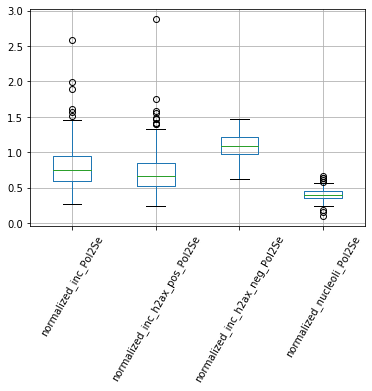

In [248]:
plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)

analysis_df.boxplot(column=['normalized_inc_Pol2Se','normalized_inc_h2ax_pos_Pol2Se',
                                      'normalized_inc_h2ax_neg_Pol2Se', 'normalized_nucleoli_Pol2Se'],rot=60)

In [249]:
analysis_df

,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_non_h2ax_within_incorporated_chr,area_control_chr,area_nucleo-excluded_control_chr,area_nucleolus,...,ave_intensity_control_chr_Pol2Se,ave_intensity_nucleo-excluded_control_chr_Pol2Se,ave_intensity_nucleolus_Pol2Se,ave_intensity_h2ax_pos_incorporated_chr_Pol2Se,ave_intensity_h2ax_neg_incorporated_chr_Pol2Se,normalized_inc_h2ax,normalized_inc_Pol2Se,normalized_inc_h2ax_pos_Pol2Se,normalized_inc_h2ax_neg_Pol2Se,normalized_nucleoli_Pol2Se
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos1,5,"[[932.3114303959131, 1333.9125159642401], 6]",226,195,13,14130,3959,10538,...,288.471591,333.119705,155.474021,235.172093,NaN,13.404355,0.807383,0.705969,NaN,0.466721
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,2,"[[314.1214727960112, 829.7470275601337], 6]",81,33,28,16802,3781,13206,...,310.387468,360.923397,125.143356,NaN,NaN,2.734593,0.451571,NaN,NaN,0.346731
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,4,"[[543.0251839568867, 1221.6801741113068], 6]",56,42,6,8565,2639,6183,...,323.554392,385.852359,158.228336,372.675755,NaN,5.194016,1.018592,0.965851,NaN,0.410075
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,6,"[[942.7058485414572, 1314.1928437993965], 6]",197,163,9,12520,3073,9668,...,233.922450,273.935053,98.123577,89.044176,NaN,6.390422,0.399919,0.325056,NaN,0.358200
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_.nd2_Pos2,7,"[[1088.0157803718114, 891.5470528894654], 6]",61,57,0,12582,3038,9655,...,218.173646,253.703627,101.011588,139.517860,NaN,7.965721,0.493650,0.549925,NaN,0.398148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_017.nd2_...,3,"[[612.4624791736088, 1106.1124625124958], 7]",704,575,58,26744,5505,21774,...,558.683466,634.016077,229.286691,318.555590,NaN,6.979839,0.607236,0.502441,NaN,0.361642
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_017.nd2_...,6,"[[676.8989557034657, 1629.8865044755566], 7]",44,42,0,16005,3295,12821,...,737.767210,848.659765,290.685718,720.737235,NaN,9.383528,0.820664,0.849265,NaN,0.342523
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_017.nd2_...,10,"[[925.750306673209, 1546.1803851815505], 7]",33,8,19,14855,2838,12095,...,598.860847,677.432998,255.200414,NaN,NaN,2.229869,1.017034,NaN,NaN,0.376717
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_017.nd2_...,14,"[[1149.3839564921823, 1674.7191026512576], 7]",40,40,0,6354,1348,5218,...,905.121324,1026.271061,343.916019,1449.179543,NaN,5.136071,1.334674,1.412083,NaN,0.335112


In [250]:
analysis_df['H2ax_pos_neg_ratio_Pol2Se'] = analysis_df['ave_intensity_h2ax_pos_incorporated_chr_Pol2Se']/analysis_df['ave_intensity_h2ax_neg_incorporated_chr_Pol2Se']

In [251]:
analysis_df[analysis_df['H2ax_pos_neg_ratio_Pol2Se']>0]

,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_non_h2ax_within_incorporated_chr,area_control_chr,area_nucleo-excluded_control_chr,area_nucleolus,...,ave_intensity_nucleo-excluded_control_chr_Pol2Se,ave_intensity_nucleolus_Pol2Se,ave_intensity_h2ax_pos_incorporated_chr_Pol2Se,ave_intensity_h2ax_neg_incorporated_chr_Pol2Se,normalized_inc_h2ax,normalized_inc_Pol2Se,normalized_inc_h2ax_pos_Pol2Se,normalized_inc_h2ax_neg_Pol2Se,normalized_nucleoli_Pol2Se,H2ax_pos_neg_ratio_Pol2Se
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_003.nd2_...,1,"[[441.5862228999536, 1630.6044884969833], 7]",229,138,66,28042,8859,19567,...,155.670940,73.117806,97.702102,164.442843,6.935070,0.781505,0.627619,1.056349,0.469695,0.594140
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_016.nd2_...,2,"[[946.2227360968368, 1171.1325225533858], 7]",192,52,101,15999,2586,13450,...,876.873722,230.585207,1091.692095,597.459896,1.896355,0.881876,1.244982,0.681352,0.262963,1.827222
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_017.nd2_...,19,"[[1106.5808680172925, 977.519666016784], 4]",466,323,113,21260,4890,16831,...,1048.503612,407.540438,986.879233,825.454140,6.597696,0.914873,0.941226,0.787269,0.388688,1.195559


In [252]:
same_cell_example_df=analysis_df[analysis_df['H2ax_pos_neg_ratio_Pol2Se']>0]

same_cell_example_df.to_excel(analysis_save_path+os.sep+"examples_with_both_damaged_positive_and_negative_areas.xlsx")

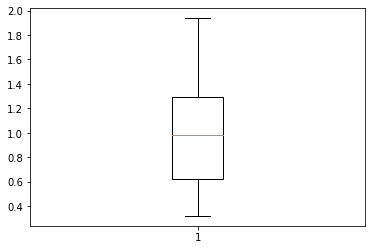

In [253]:
boxplot_same_foci= plt.boxplot(pos_neg_ratio[pos_neg_ratio>0])

In [254]:
analysis_df['h2ax_damage_level']=analysis_df['area_h2ax_within_incorporated_chr']/analysis_df['area_incorporated_chr']

damaged_chr_df = analysis_df[analysis_df['h2ax_damage_level']>=0.5]

partial_damaged_chr_df = analysis_df[analysis_df['h2ax_damage_level']<0.5]

med_damaged_chr_df = partial_damaged_chr_df[partial_damaged_chr_df['h2ax_damage_level']>=0.2]

no_damaged_chr_df = partial_damaged_chr_df[partial_damaged_chr_df['h2ax_damage_level']<0.2]

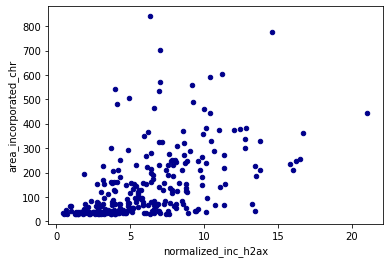

In [255]:
analysis_df.plot.scatter(x='normalized_inc_h2ax',y='area_incorporated_chr',c='DarkBlue')

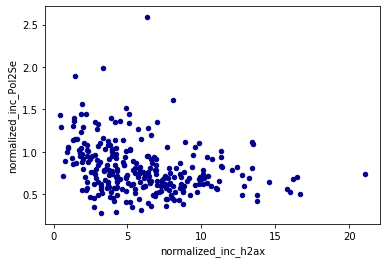

In [256]:
analysis_df.plot.scatter(x='normalized_inc_h2ax',y='normalized_inc_Pol2Se',c='DarkBlue')

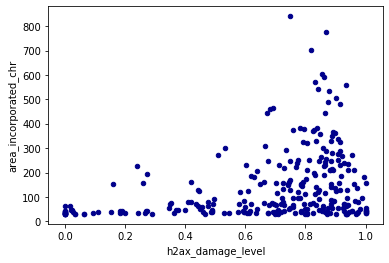

In [219]:
analysis_df.plot.scatter(x='h2ax_damage_level',y='area_incorporated_chr',c='DarkBlue')

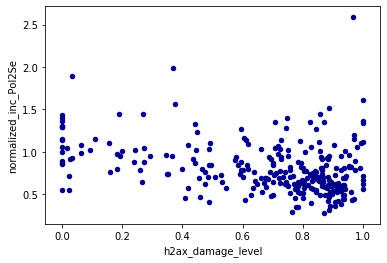

In [257]:
analysis_df.plot.scatter(x='h2ax_damage_level',y='normalized_inc_Pol2Se',c='DarkBlue')

In [258]:
print(damaged_chr_df['normalized_inc_Pol2Se'].mean())
print(damaged_chr_df['area_incorporated_chr'].mean())



print(med_damaged_chr_df['normalized_inc_Pol2Se'].mean())
print(med_damaged_chr_df['area_incorporated_chr'].mean())



print(no_damaged_chr_df['normalized_inc_Pol2Se'].mean())
print(no_damaged_chr_df['area_incorporated_chr'].mean())

#len(damaged_chr_df)
#len(med_damaged_chr_df)
#len(no_damaged_chr_df)

#len(analysis_df)

#no_damaged_chr_df['area_incorporated_chr'].mean()
#damaged_chr_df['area_incorporated_chr'].mean()

#analysis_df['area_h2ax_within_incorporated_chr'].mean()

#analysis_df['area_non_h2ax_within_incorporated_chr'].mean()

0.7508748825334279
168.56338028169014
0.9183822245081104
71.94285714285714
1.0648545051284226
41.5


c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


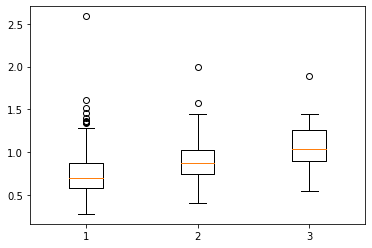

In [259]:
boxplot_pol2= plt.boxplot([damaged_chr_df['normalized_inc_Pol2Se'],med_damaged_chr_df['normalized_inc_Pol2Se'],no_damaged_chr_df['normalized_inc_Pol2Se']])

c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


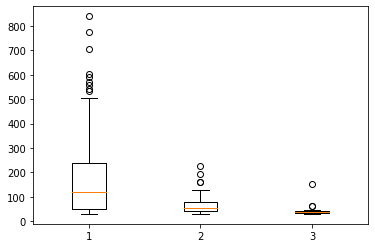

In [260]:
boxplot_size= plt.boxplot([damaged_chr_df['area_incorporated_chr'],med_damaged_chr_df['area_incorporated_chr'],no_damaged_chr_df['area_incorporated_chr']])

In [263]:
len(med_damaged_chr_df)

len(no_damaged_chr_df)

len(damaged_chr_df)

213

In [123]:
no_damaged_chr_df[no_damaged_chr_df['area_incorporated_chr']==151]

,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_non_h2ax_within_incorporated_chr,area_control_chr,area_nucleo-excluded_control_chr,area_nucleolus,...,ave_intensity_control_chr_Pol2Se,ave_intensity_nucleo-excluded_control_chr_Pol2Se,ave_intensity_nucleolus_Pol2Se,ave_intensity_h2ax_pos_incorporated_chr_Pol2Se,ave_intensity_h2ax_neg_incorporated_chr_Pol2Se,normalized_inc_Pol2Se,normalized_inc_h2ax_pos_Pol2Se,normalized_inc_h2ax_neg_Pol2Se,normalized_nucleoli_Pol2Se,h2ax_damage_level
0,cov2_Mdc1-488 H2AX-568 PolS5-647,cov2_RPE1 Mdc1-488 H2AX-568 PolS5-647_017.nd2_...,1,"[[511.4927644091623, 1047.8698585958819], 5]",151,24,127,55869,18084,38502,...,153.648219,184.904014,83.72614,NaN,154.030648,0.765605,NaN,0.83303,0.452809,0.15894
